In [1]:
from jax import numpy as jnp
import jax
import optax
from sklearn.metrics import accuracy_score
from quantum_model import quantum_neural_network
import pennylane as qml
from load_data import RandomMnist
from sklearn.utils import gen_batches

In [2]:
import numpy as np

In [3]:
@jax.jit
def binary_crossentropy(x, y, theta):
    labels = jnp.array(y)
    pred = jnp.array(qnn(x, theta))
    loss = 0
    for l, p in zip(labels, pred):
        loss += l * (jnp.log(p[l])) + (1 - l) * jnp.log(1 - p[1 - l])
    return -jnp.sum(loss)/len(labels)

@jax.jit
def optimizer_update(opt_state, params, x, y):
    loss_value, grads = jax.value_and_grad(lambda theta: binary_crossentropy(x, y, theta))(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

def calculate_accuracy(X, y, params):
    labels = jnp.array(y)
    predictions = jnp.array(qnn(X, params))
    predicted_labels = jnp.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predicted_labels)
    return accuracy

In [4]:
@jax.jit
def accuracy(X, y, params):
    labels = jnp.array(y)
    predictions = jnp.array(qnn(X, params))
    correct_predictions = jnp.sum(jnp.argmax(predictions, axis=1) == labels)
    return correct_predictions / len(labels)

@jax.jit  
def acc(x, y, theta):
    accuracy = jnp.mean(jnp.argmax(qnn(x, theta), -1) == y)
    return accuracy

In [5]:
layers1 = 2
n_qubits = 8
dev = qml.device('default.qubit', wires=n_qubits)

@qml.qnode(dev, interface='jax')
def quantum_nn(X, thetas):
    model = quantum_neural_network(n_wires=n_qubits)
    params_per_sublayer = 69
    for layer in range(layers1):
        model.QuantumMap(X)
        qml.Barrier()
        j = layer * params_per_sublayer
        model.QuantumRing_layer(thetas[j:j+(params_per_sublayer)],)
        j += (params_per_sublayer)*(layer)
        qml.Barrier(wires=range(n_qubits),only_visual=True)
    qml.Barrier(wires=range(n_qubits),only_visual=True)
    return qml.probs(wires=0)

In [14]:
lr = 0.01
n_epochs = 200
batch_size = 32
seed = 1234
param_per_gate = 3
entangling_gate = 7
new_shape = 8
dataset = RandomMnist(classes_of_items=[0, 1], num_train_samples=500, shuffle=True, resize=new_shape, my_seed=999)
X_train, y_train, X_val, y_val = dataset.data()
qnn_batched = jax.vmap(quantum_nn, (0, None,))
qnn = jax.jit(qnn_batched)
optimizer = optax.adam(learning_rate=lr)

In [15]:
key = jax.random.PRNGKey(seed)
initial_params = jax.random.normal(key, shape=((param_per_gate * n_qubits + param_per_gate * entangling_gate +
                                                param_per_gate * n_qubits) * layers1,))
key = jax.random.split(key)[0]
params = jnp.copy(initial_params)
opt_state = optimizer.init(initial_params)

train_cost_epochs, train_acc_epochs, val_cost_epochs, val_acc_epochs = [], [], [], []
'''costs, val_costs, accs, val_accs = [], [], [], []'''
for epoch in range(1,n_epochs+1):
    idxs_dataset = jax.random.choice(key, jnp.array(list(range(X_train.shape[0]))), shape=(X_train.shape[0],), replace=False)
    key = jax.random.split(key)[0]
    for i in gen_batches(X_train.shape[0], batch_size):
        idxs = idxs_dataset[i]
        params, opt_state, cost = optimizer_update(opt_state, params, X_train[idxs, :], y_train[idxs])
        '''params, opt_state, cost = optimizer_update(opt_state, params, X_train, y_train)'''
        cost = binary_crossentropy(X_train, y_train, params,)
        val_cost = binary_crossentropy(X_val, y_val, params,)
        train_acc = accuracy(X_train, y_train, params,) 
        val_acc = accuracy(X_val, y_val, params,)
    train_cost_epochs.append(cost)
    val_cost_epochs.append(val_cost)
    # Accuracy during training and validation
    train_acc_epochs.append(train_acc)
    val_acc_epochs.append(val_acc)
    print(f"Epoch: {epoch}, ---Train loss: ", cost, "---Val loss: ", val_cost, "---Train acc: ", train_acc,
          "---Val acc.: ", val_acc)
    optimal_params = params  # Optimal parameters after training
    #path = "/Users/francescoaldoventurelli/Desktop/"
    #np.save(path + "trained_weight_file_1layer.npy", optimal_params)

Epoch: 1, ---Train loss:  0.7143221 ---Val loss:  0.7143221 ---Train acc:  0.51 ---Val acc.:  0.48
Epoch: 2, ---Train loss:  0.6512728 ---Val loss:  0.6512728 ---Train acc:  0.73499995 ---Val acc.:  0.65999997
Epoch: 3, ---Train loss:  0.6707589 ---Val loss:  0.6707589 ---Train acc:  0.71999997 ---Val acc.:  0.61
Epoch: 4, ---Train loss:  0.59842545 ---Val loss:  0.59842545 ---Train acc:  0.7175 ---Val acc.:  0.59999996
Epoch: 5, ---Train loss:  0.62568235 ---Val loss:  0.62568235 ---Train acc:  0.72249997 ---Val acc.:  0.59999996
Epoch: 6, ---Train loss:  0.5705313 ---Val loss:  0.5705313 ---Train acc:  0.72249997 ---Val acc.:  0.59999996
Epoch: 7, ---Train loss:  0.58586967 ---Val loss:  0.58586967 ---Train acc:  0.71999997 ---Val acc.:  0.59
Epoch: 8, ---Train loss:  0.6122945 ---Val loss:  0.6122945 ---Train acc:  0.71999997 ---Val acc.:  0.59
Epoch: 9, ---Train loss:  0.6043771 ---Val loss:  0.6043771 ---Train acc:  0.72499996 ---Val acc.:  0.59
Epoch: 10, ---Train loss:  0.498232

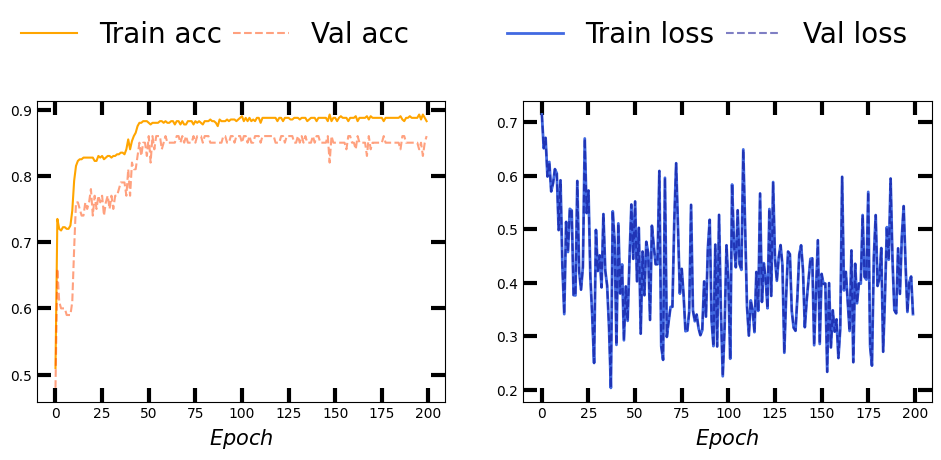

In [16]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(train_acc_epochs, label="Train acc", color="orange")
axs[0].plot(val_acc_epochs, label="Val acc", color="orangered", alpha=0.5, ls='--')
axs[0].set_xlabel("Epoch")
axs[1].plot(train_cost_epochs, label="Train loss", color="royalblue", mfc='white', markersize=6, lw=2)
axs[1].plot(val_cost_epochs, label="Val loss", color="darkblue", alpha=0.5, mfc='white', markersize=6, ls='--')
axs[1].set_xlabel("Epoch")
axs[1].legend(fontsize=20, framealpha=0, ncol=2, columnspacing=0.4, loc='upper left', bbox_to_anchor=(-0.1, 1.35))
axs[0].legend(fontsize=20, framealpha=0, ncol=2, columnspacing=0.4, loc='upper left', bbox_to_anchor=(-0.1, 1.35))
axs[0].set_xlabel(r'$Epoch$', fontsize=15)
axs[1].set_xlabel(r'$Epoch$', fontsize=15)
axs[0].tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=10)
axs[1].tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=10)
plt.tight_layout()

(<Figure size 2200x900 with 1 Axes>, <Axes: >)

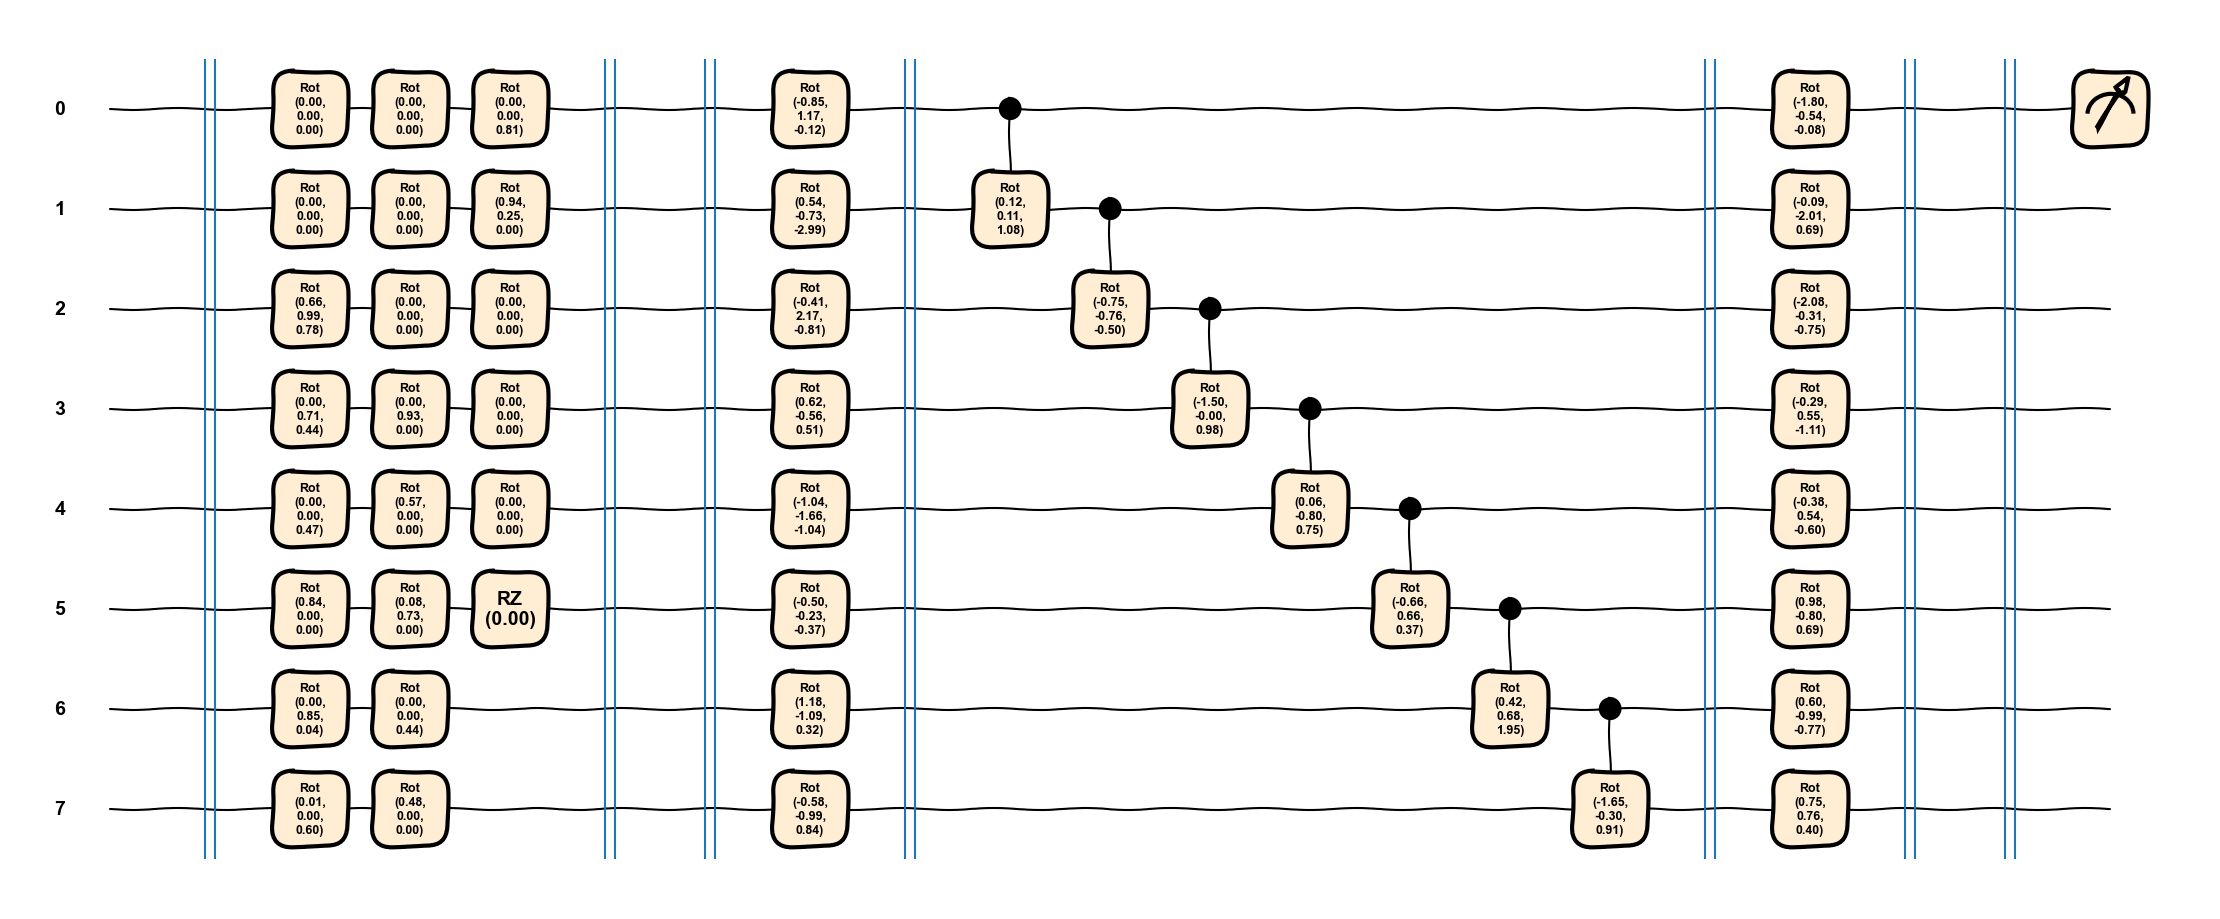

In [11]:
qml.draw_mpl(qnode=quantum_nn, style="sketch", decimals=2)(X_train[0], initial_params)

## Test evaluation

In [9]:
from keras.datasets import mnist
import numpy as np
import tensorflow as tf

from load_data import down_sample
classes_of_items = [0,1]
num_samples_per_class = 300

(_, _), (X_test, y_test) = mnist.load_data()

mask = np.isin(y_test, classes_of_items)
X_test_filtered = X_test[mask]
y_test_filtered = y_test[mask]

X_test_new = [down_sample(x_test, 8) for x_test in X_test_filtered]
X_test_final = np.array(X_test_new).reshape(len(X_test_new), -1) / 255.0
y_test_final = np.array(y_test_filtered)

selected_indices = []
for class_idx in classes_of_items:
    class_indices = np.where(y_test_filtered == class_idx)[0][:int(num_samples_per_class/2)]
    selected_indices.extend(class_indices)

# Shuffle selected indices
np.random.shuffle(selected_indices)


X_test_final = X_test_final[selected_indices]
y_test_final = y_test_final[selected_indices]
X_test_final = jnp.asarray(X_test_final)
y_test_final = jnp.asarray(y_test_final)

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [11]:
def prediction(ytrue, qnn, opt_weights):
    ypred = jnp.array(qnn(X_test_final.T, opt_weights))
    estimated_lab = jnp.array([jnp.argmax(label) for label in ypred])
    return [np.round(accuracy_score(jnp.array(ytrue), estimated_lab),2), estimated_lab]

In [12]:
prediction(y_test_final, quantum_nn, optimal_params)[0]

0.86

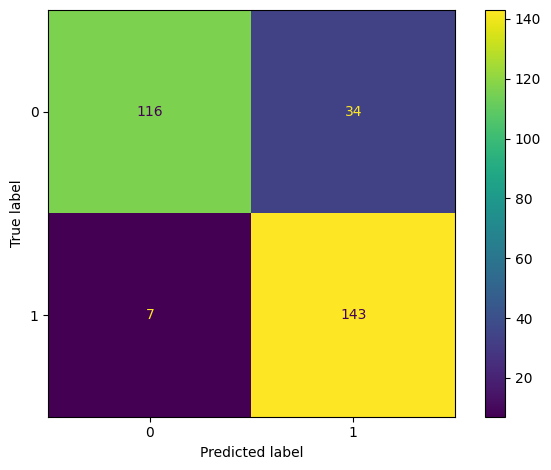

In [13]:
plt.style.use("default")
ConfusionMatrixDisplay(confusion_matrix(y_true=y_test_final, y_pred=prediction(y_test_final, quantum_nn, optimal_params)[1])).plot()

plt.tight_layout()

In [103]:
def training(qnn_batched, lys):
    qnn = jax.jit(qnn_batched)
    key = jax.random.PRNGKey(seed)
    initial_params = jax.random.normal(key, shape=((param_per_gate * n_qubits + param_per_gate * entangling_gate +
                                                    param_per_gate * n_qubits) * lys,))
    key = jax.random.split(key)[0]
    params = jnp.copy(initial_params)
    opt_state = optimizer.init(initial_params)
    
    train_cost_epochs, train_acc_epochs, val_cost_epochs, val_acc_epochs = [], [], [], []
    
    for epoch in range(1,n_epochs+1):
        idxs_dataset = jax.random.choice(key, jnp.array(list(range(X_train.shape[0]))), shape=(X_train.shape[0],), replace=False)
        key = jax.random.split(key)[0]
        for i in gen_batches(X_train.shape[0], batch_size):
            idxs = idxs_dataset[i]
            params, opt_state, cost = optimizer_update(opt_state, params, X_train[idxs, :], y_train[idxs])
            '''params, opt_state, cost = optimizer_update(opt_state, params, X_train, y_train)'''
            cost = binary_crossentropy(X_train, y_train, params,)
            val_cost = binary_crossentropy(X_val, y_val, params,)
            train_acc = accuracy(X_train, y_train, params,)
            val_acc = accuracy(X_val, y_val, params,)
        train_cost_epochs.append(cost)
        val_cost_epochs.append(val_cost)
        # Accuracy during training and validation
        train_acc_epochs.append(train_acc)
        val_acc_epochs.append(val_acc)
        print(f"Epoch: {epoch}, ---Train loss: ", cost, "---Val loss: ", val_cost, "---Train acc:", train_acc, "---Val acc.:", val_acc)
        optimal_params = params  # Optimal parameters after training
        path = "/Users/francescoaldoventurelli/Desktop/"
        np.save(path + "trained_weight_file_1layer.npy", optimal_params)
    return (
        train_cost_epochs,
        val_cost_epochs,
        train_acc_epochs,
        val_acc_epochs,
        optimal_params
    )

In [60]:
loss_train, loss_val, acc_train, acc_val, optimal_params = training(quantum_nn)

TypeError: training() missing 1 required positional argument: 'lys'

In [104]:
layers2 = 2
layers3 = 3
n_qubits = 8
dev = qml.device('default.qubit', wires=n_qubits)


@qml.qnode(dev, interface='jax')
def quantum_nn2(X, thetas):
    model = quantum_neural_network(n_wires=n_qubits)
    params_per_sublayer = 69
    for layer in range(layers2):
        model.QuantumMap(X)
        qml.Barrier()
        j = layer * params_per_sublayer
        model.QuantumRing_layer(thetas[j:j + (params_per_sublayer)], )
        j += (params_per_sublayer) * (layer)
        qml.Barrier(wires=range(n_qubits), only_visual=True)
    qml.Barrier(wires=range(n_qubits), only_visual=True)
    return qml.probs(wires=0)


@qml.qnode(dev, interface='jax')
def quantum_nn3(X, thetas):
    model = quantum_neural_network(n_wires=n_qubits)
    params_per_sublayer = 69
    for layer in range(layers3):
        model.QuantumMap(X)
        qml.Barrier()
        j = layer * params_per_sublayer
        model.QuantumRing_layer(thetas[j:j + (params_per_sublayer)], )
        j += (params_per_sublayer) * (layer)
        qml.Barrier(wires=range(n_qubits), only_visual=True)
    qml.Barrier(wires=range(n_qubits), only_visual=True)
    return qml.probs(wires=0)

In [105]:
trainlosses = np.zeros((500, 3))
vallosses = np.zeros((500, 3))
trainaccs = np.zeros((500, 3))
vallaccs = np.zeros((500, 3))
opt_weights_list = []
reuploadings = [layers1, layers2, layers3]
quantum_nn_list = [quantum_nn, quantum_nn2, quantum_nn3]

for i, layers in enumerate(reuploadings):
    tr_loss, vl_loss, tr_acc, vl_acc, opt_weights = training(quantum_nn_list[i], layers)
    trainlosses[:, i] = tr_loss
    vallosses[:, i] = vl_loss
    trainaccs[:, i] = tr_acc
    vallaccs[:, i] = vl_acc
    opt_weights_list.append(opt_weights)

Epoch: 1, ---Train loss:  0.6854232 ---Val loss:  0.7037377 ---Train acc: 0.4475 ---Val acc.: 0.45
Epoch: 2, ---Train loss:  0.7628715 ---Val loss:  0.7001657 ---Train acc: 0.465 ---Val acc.: 0.44
Epoch: 3, ---Train loss:  0.70566237 ---Val loss:  0.6863282 ---Train acc: 0.615 ---Val acc.: 0.65999997
Epoch: 4, ---Train loss:  0.684165 ---Val loss:  0.68077064 ---Train acc: 0.6375 ---Val acc.: 0.71
Epoch: 5, ---Train loss:  0.71524125 ---Val loss:  0.67396486 ---Train acc: 0.64 ---Val acc.: 0.71
Epoch: 6, ---Train loss:  0.65296257 ---Val loss:  0.6615078 ---Train acc: 0.615 ---Val acc.: 0.63
Epoch: 7, ---Train loss:  0.69614005 ---Val loss:  0.65814537 ---Train acc: 0.6275 ---Val acc.: 0.69
Epoch: 8, ---Train loss:  0.60000056 ---Val loss:  0.6525855 ---Train acc: 0.6225 ---Val acc.: 0.68
Epoch: 9, ---Train loss:  0.65917295 ---Val loss:  0.6483678 ---Train acc: 0.6375 ---Val acc.: 0.69
Epoch: 10, ---Train loss:  0.620394 ---Val loss:  0.64611584 ---Train acc: 0.6475 ---Val acc.: 0.71


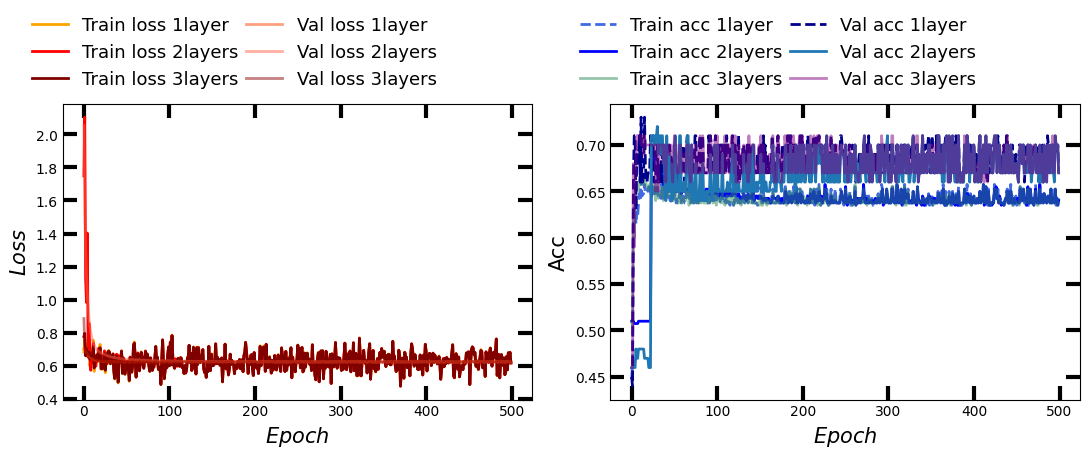

In [106]:
fig, axs = plt.subplots(1, 2, figsize=(11, 5))
axs[0].plot(trainlosses[:,0], label="Train loss 1layer", color="orange",mfc='white', markersize=4, lw=2)
axs[0].plot(trainlosses[:,1], label="Train loss 2layers", color="red",mfc='white', markersize=4, lw=2)
axs[0].plot(trainlosses[:,2], label="Train loss 3layers", color="maroon",mfc='white', markersize=4, lw=2)
axs[0].plot(vallosses[:,0], label="Val loss 1layer", color="orangered", alpha=0.5,mfc='white', markersize=4, lw=2)
axs[0].plot(vallosses[:,1], label="Val loss 2layers", color="tomato", alpha=0.5,mfc='white', markersize=4, lw=2)
axs[0].plot(vallosses[:,2], label="Val loss 3layers", color="darkred", alpha=0.5,mfc='white', markersize=4, lw=2)
axs[0].set_xlabel("Epoch")
axs[1].plot(trainaccs[:, 0], label="Train acc 1layer", color="royalblue", mfc='white', markersize=4, lw=2, ls='--')
axs[1].plot(trainaccs[:, 1], label="Train acc 2layers", color="blue", mfc='white', markersize=4, lw=2)
axs[1].plot(trainaccs[:, 2], label="Train acc 3layers", color="seagreen", mfc='white', markersize=4, lw=2, alpha=0.5)
axs[1].plot(vallaccs[:, 0], label="Val acc 1layer", color="darkblue", mfc='white', markersize=4, lw=2, ls='--')
axs[1].plot(vallaccs[:, 1], label="Val acc 2layers", color="tab:blue", mfc='white', markersize=4, lw=2)
axs[1].plot(vallaccs[:, 2], label="Val acc 3layers", color="purple", mfc='white', markersize=4, lw=2, alpha=0.5)
axs[1].set_xlabel("Epoch")
axs[1].legend(fontsize=13, framealpha=0, ncol=2, columnspacing=0.4, loc='upper left', bbox_to_anchor=(-0.1, 1.35))
axs[0].legend(fontsize=13, framealpha=0, ncol=2, columnspacing=0.4, loc='upper left', bbox_to_anchor=(-0.1, 1.35))
axs[0].set_xlabel(r'$Epoch$', fontsize=15)
axs[0].set_ylabel(r"$Loss$", fontsize=15)
axs[1].set_ylabel(r"Acc", fontsize=15)
axs[1].set_xlabel(r'$Epoch$', fontsize=15)
axs[0].tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=10)
axs[1].tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=10)
plt.tight_layout()

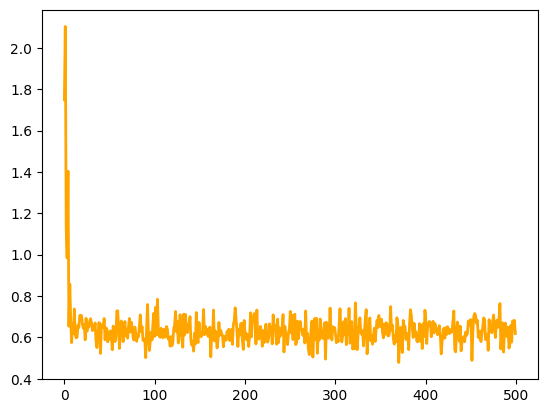

In [108]:
plt.plot(trainlosses[:,1], label="Train loss 1layer", color="orange",mfc='white', markersize=4, lw=2)

In [27]:
from jax_training import make_test

In [28]:
Xtest, ytest = make_test([0,1], 8, 55)

In [29]:
Xtest = jnp.asarray(Xtest)
ytest = jnp.asarray(ytest)

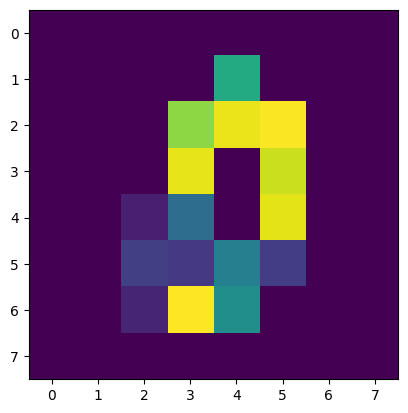

In [31]:
plt.imshow(Xtest[0].reshape((8,8)))
plt.show()

In [32]:
quantum_nn_list

[<QNode: wires=8, device='default.qubit.jax', interface='jax', diff_method='best'>,
 <QNode: wires=8, device='default.qubit.jax', interface='jax', diff_method='best'>,
 <QNode: wires=8, device='default.qubit.jax', interface='jax', diff_method='best'>]

In [33]:
def downsample(x_array, size):
    newsize = (size, size)
    x_array = np.reshape(x_array, (x_array.shape[0], x_array.shape[1], 1))
    new_array = tf.image.resize(x_array, newsize)
    return new_array.numpy() 


def data(num_train_samples=None, num_test_samples=100, shuffle=False, resize=8): 
    (train_X, train_y), (test_X, test_y) = mnist.load_data()
    
    X_test_filtered = test_X[np.isin(test_y, [0,1])]
    y_test_filtered = test_y[np.isin(test_y, [0,1])]

   
    X_test_filtered = X_test_filtered.astype('float32') / 255
    X_test_new = []
    if resize is not None and resize <= 28:
        for test in X_test_filtered:
            X_test_new.append(downsample(test, resize))
    else: 
        raise Exception("The new size must be smaller than the actual Mnist size that is 28!")

    ### shuffle
    X_test_new = np.array(X_test_new)
    test_indices = np.arange(len(X_test_new))
    if shuffle == True:
        np.random.shuffle(test_indices)

    if num_test_samples is not None:
        X_test_ = np.array(X_test_new)[:num_test_samples]
        y_test_filtered = y_test_filtered[:num_test_samples]
        X_test_ = X_test_.reshape(X_test_.shape[0], X_test_.shape[1]*X_test_.shape[2])
    return (
        jnp.asarray(X_test_),
        jnp.asarray(y_test_filtered),
    )

Xtest2, ytest2 = data()

In [64]:
def predict(optimal_weights, qnn):
    ypred = jnp.asarray(qnn(Xtest2, optimal_weights))
    print(ypred.shape)
    estimated_labels = jnp.array([jnp.argmax(label) for label in ypred])
    return np.round(accuracy_score(ytest2, estimated_labels),2)


predict(opt_weights_list[0], quantum_nn_list[0])

(64, 2)


ValueError: Found input variables with inconsistent numbers of samples: [100, 64]

In [109]:
tot_accuracy_test = []
for i in range(3):
    ypred = []
    for x in Xtest2:
        estimated_labels = quantum_nn_list[i](x, opt_weights_list[i])
        ypred.append(jnp.argmax(estimated_labels))
    tot_accuracy_test.append(accuracy_score(ytest2, ypred))
print(tot_accuracy_test)

[0.62, 0.64, 0.8]


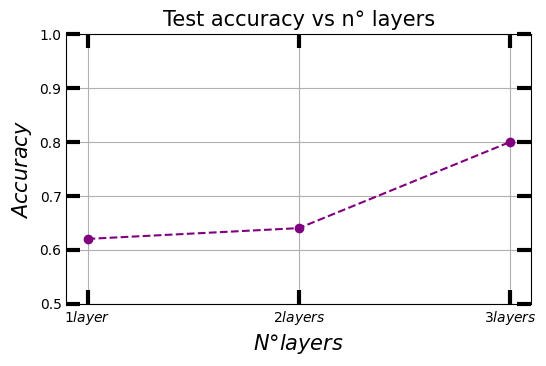

In [110]:
layer_array = np.array(["$1 layer$", "$2 layers$", "$3 layers$"])
accuracy_array = np.array(tot_accuracy_test)

plt.figure(figsize=(6,3.5))
plt.plot(layer_array, accuracy_array,  marker='o', color='purple', ls='--')
plt.xlabel(r'$N° layers$', fontsize=15)
plt.ylabel(r'$Accuracy$', fontsize=15)
plt.title(r'Test accuracy vs n° layers', fontsize=15)
plt.grid(visible=0.2)
plt.ylim(0.5,1.0)
plt.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=10)
plt.show()

In [241]:
opt_weights_list[0]

Array([ 2.0945840e+00,  1.5247006e+00,  5.3460084e-02,  1.5430298e+00,
       -7.4137235e-01, -2.9908504e+00, -3.7036533e+00,  3.2483821e+00,
        2.8196111e+00, -3.0917256e+00, -1.0147156e+00, -2.7346935e+00,
       -3.8285744e+00, -2.5962195e+00, -9.9373531e-01, -1.6105508e+00,
        2.5033584e+00, -1.2722158e+00,  1.6628281e+00, -2.8572136e-01,
       -2.0112749e-02,  8.9292836e-01, -2.7770075e-01,  2.3998232e+00,
        6.3861877e-01,  1.4704612e+00,  2.4281547e+00, -7.7116162e-01,
       -2.0638568e+00,  4.0878613e-02, -1.0403223e+00, -4.6072185e-02,
        1.1495771e+00, -2.5511029e-01, -3.0824444e-01,  5.4618567e-01,
       -1.1451378e-01,  5.0212461e-01,  8.0541331e-01,  7.6622236e-01,
        1.9967209e-01,  2.5393279e+00, -1.5193044e+00, -2.5391150e-01,
        7.7857107e-01, -1.6282123e+00, -1.2151031e+00, -2.2406451e-01,
        4.1465670e-01, -1.6755711e+00,  8.4035873e-01, -2.3900545e+00,
        2.4749844e-03, -8.8633347e-01, -1.0753967e+00, -1.0060709e+00,
      

In [225]:
@qml.qnode(dev, interface='jax')
def quantum_nn3_TEST(X, thetas):
    model = quantum_neural_network(n_wires=n_qubits)
    params_per_sublayer = 69
    for layer in range(layers3):
        model.QuantumMap(X)
        qml.Barrier()
        j = layer * params_per_sublayer
        model.QuantumRing_layer(thetas[j:j + (params_per_sublayer)], )
        j += (params_per_sublayer) * (layer)
        qml.Barrier(wires=range(n_qubits), only_visual=True)
    qml.Barrier(wires=range(n_qubits), only_visual=True)
    return qml.probs(wires=0)

In [226]:
ypred = jnp.asarray(quantum_nn3_TEST(Xtest, opt_weights_list[2]))
estimated_labels = jnp.array([jnp.argmax(label) for label in ypred])
np.round(accuracy_score(ytest, estimated_labels),2)

ValueError: Found input variables with inconsistent numbers of samples: [300, 64]

In [196]:
ypred.shape

(64, 2)

In [197]:
estimated_labels = jnp.array([jnp.argmax(label) for label in ypred])

In [198]:
estimated_labels

Array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],      dtype=int32)

In [179]:
print("Shape of y_test_final:", y_test_final.shape)
print("Shape of estimated_labels:", estimated_labels.shape)

Shape of y_test_final: (300,)
Shape of estimated_labels: (64,)


In [174]:
np.round(accuracy_score(y_test_final, estimated_labels),2)

ValueError: Found input variables with inconsistent numbers of samples: [10000, 64]

In [162]:
def predict(optimal_weights, qnn):
    ypred = jnp.asarray(qnn(X_test_final, optimal_weights))
    estimated_labels = jnp.array([jnp.argmax(label) for label in ypred])
    return (estimated_labels, np.round(accuracy_score(y_test_final, estimated_labels),2))

predictions = [predict(opt_weights_list[i], quantum_nn_list[i])[1] for i in range(2)]
predictions

ValueError: Found input variables with inconsistent numbers of samples: [300, 64]

# Only 1 layer

In [119]:
layers = 1   
n_qubits = 8
dev = qml.device('default.qubit', wires=n_qubits)

@qml.qnode(dev, interface='jax')
def quantum_nn(X, thetas):
    model = quantum_neural_network(n_wires=n_qubits)
    params_per_sublayer = 69
    for layer in range(layers):
        model.QuantumMap(X)
        qml.Barrier()
        j = layer * params_per_sublayer
        model.QuantumRing_layer(thetas[j:j+(params_per_sublayer)],)
        j += (params_per_sublayer)*(layer)
        qml.Barrier(wires=range(n_qubits),only_visual=True)
    qml.Barrier(wires=range(n_qubits),only_visual=True)
    return qml.probs(wires=0)


lr = 0.01
n_epochs = 500
batch_size = 16
seed = 123
param_per_gate = 3
entangling_gate = 7
new_shape = 8
dataset = RandomMnist(classes_of_items=[0, 1], num_train_samples=500, shuffle=True, resize=new_shape, my_seed=999)
X_train, y_train, X_val, y_val = dataset.data()
qnn_batched = jax.vmap(quantum_nn, (0, None,))
qnn = jax.jit(qnn_batched)
optimizer = optax.adam(learning_rate=lr)

key = jax.random.PRNGKey(seed)
initial_params = jax.random.normal(key, shape=((param_per_gate * n_qubits + param_per_gate * entangling_gate +
                                                param_per_gate * n_qubits) * layers,))
key = jax.random.split(key)[0]
params = jnp.copy(initial_params)
opt_state = optimizer.init(initial_params)

train_cost_epochs, train_acc_epochs, val_cost_epochs, val_acc_epochs = [], [], [], []

for epoch in range(1,n_epochs+1):
    idxs_dataset = jax.random.choice(key, jnp.array(list(range(X_train.shape[0]))), shape=(X_train.shape[0],), replace=False)
    key = jax.random.split(key)[0]
    for i in gen_batches(X_train.shape[0], batch_size):
        idxs = idxs_dataset[i]
        params, opt_state, cost = optimizer_update(opt_state, params, X_train[idxs, :], y_train[idxs])
        '''params, opt_state, cost = optimizer_update(opt_state, params, X_train, y_train)'''
    cost = binary_crossentropy(X_train, y_train, params,)
    val_cost = binary_crossentropy(X_val, y_val, params,)
    train_cost_epochs.append(cost)
    val_cost_epochs.append(val_cost)
    # Accuracy during training and validation
    train_acc = calculate_accuracy(X_train, y_train, params,)
    val_acc = calculate_accuracy(X_val, y_val, params,)
    train_acc_epochs.append(train_acc)
    val_acc_epochs.append(val_acc)
    print(f"Epoch: {epoch}, ---Train loss: ", cost, "---Val loss: ", val_cost, "---Train acc:", train_acc, "---Val acc.:", val_acc)
    optimal_params = params  # Optimal parameters after training

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x10cf96170>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


Epoch: 1, ---Train loss:  0.7045384 ---Val loss:  0.703839 ---Train acc: 0.4625 ---Val acc.: 0.44
Epoch: 2, ---Train loss:  0.6936617 ---Val loss:  0.69124466 ---Train acc: 0.4575 ---Val acc.: 0.46
Epoch: 3, ---Train loss:  0.68241256 ---Val loss:  0.67782235 ---Train acc: 0.6225 ---Val acc.: 0.69
Epoch: 4, ---Train loss:  0.6709598 ---Val loss:  0.66742986 ---Train acc: 0.6325 ---Val acc.: 0.69
Epoch: 5, ---Train loss:  0.6614686 ---Val loss:  0.65858704 ---Train acc: 0.6325 ---Val acc.: 0.7
Epoch: 6, ---Train loss:  0.65415305 ---Val loss:  0.64685494 ---Train acc: 0.63 ---Val acc.: 0.64
Epoch: 7, ---Train loss:  0.64707303 ---Val loss:  0.64657277 ---Train acc: 0.6475 ---Val acc.: 0.71
Epoch: 8, ---Train loss:  0.64209354 ---Val loss:  0.63905406 ---Train acc: 0.645 ---Val acc.: 0.66
Epoch: 9, ---Train loss:  0.63777596 ---Val loss:  0.6368506 ---Train acc: 0.645 ---Val acc.: 0.66
Epoch: 10, ---Train loss:  0.63493854 ---Val loss:  0.6341583 ---Train acc: 0.645 ---Val acc.: 0.66
Epo

KeyboardInterrupt: 

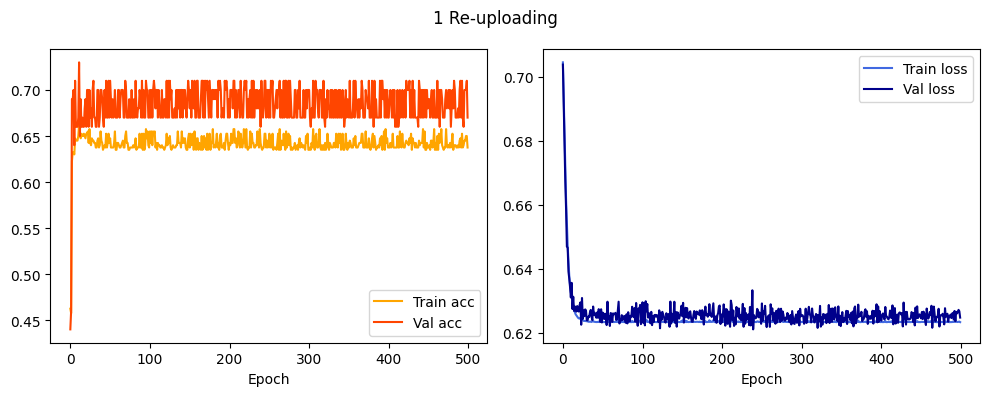

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle("1 Re-uploading")
axs[0].plot(train_acc_epochs, label="Train acc", color="orange")
axs[0].plot(val_acc_epochs, label="Val acc", color="orangered")
axs[0].set_xlabel("Epoch")
axs[1].plot(train_cost_epochs, label="Train loss", color="royalblue")
axs[1].plot(val_cost_epochs, label="Val loss", color="darkblue")
axs[1].set_xlabel("Epoch")
axs[0].legend(loc="best")
axs[1].legend(loc="upper right")
plt.tight_layout()

In [48]:
y_predicted = jnp.asarray(qnn(X_test_final, optimal_params))
estimated_labels = jnp.array([jnp.argmax(label) for label in y_predicted])
np.round(accuracy_score(y_test_final, estimated_labels),2)

0.68

(<Figure size 2200x900 with 1 Axes>, <Axes: >)

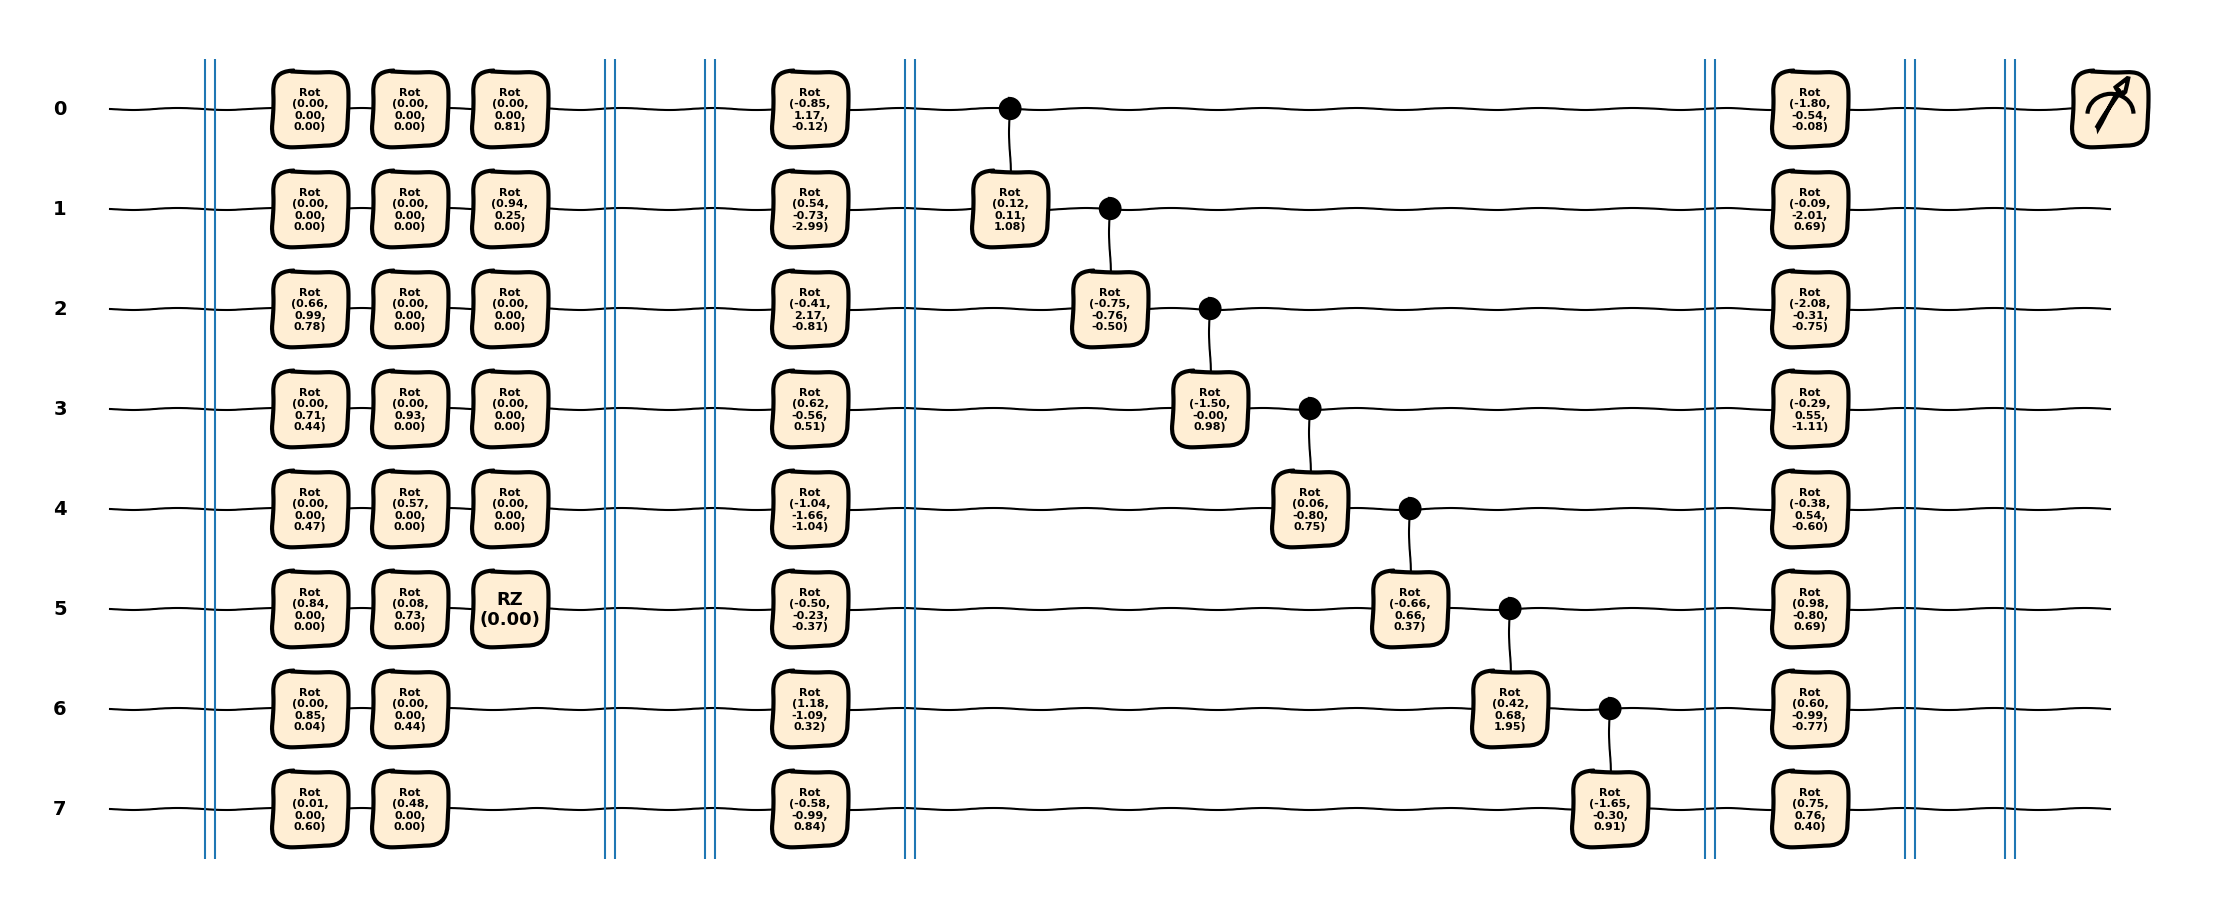

In [49]:
qml.draw_mpl(qnode=quantum_nn, style="sketch", decimals=2)(X_train[0], initial_params)

In [ ]:
dev = qml.device('default.qubit', wires=n_qubits)
@qml.qnode(dev, interface='jax')
def quantum_nn(X, thetas, reuploading):
    model = quantum_neural_network(n_wires=n_qubits)
    params_per_sublayer = 69
    for layer in range(reuploading):
        model.QuantumMap(X)
        qml.Barrier()
        j = layer * params_per_sublayer
        model.QuantumRing_layer(thetas[j:j+(params_per_sublayer)],)
        j += (params_per_sublayer)*(layer)
        qml.Barrier(wires=range(n_qubits), only_visual=True)
    qml.Barrier(wires=range(n_qubits), only_visual=True)
    return qml.probs(wires=0)

In [64]:
from train import training_process

ImportError: cannot import name 'training_process' from 'train' (/Users/francescoaldoventurelli/qml/QuantumJAX/train.py)

In [55]:
layers = 2
n_qubits = 8
lr = 0.01
n_epochs = 500
batch_size = 16
seed = 123
param_per_gate = 3
entangling_gate = 7
new_shape = 8
dataset = RandomMnist(classes_of_items=[0, 1], num_train_samples=500, shuffle=True, resize=new_shape, my_seed=999)
X_train, y_train, X_val, y_val = dataset.data()

In [56]:
dev = qml.device('default.qubit', wires=n_qubits)

@qml.qnode(dev, interface='jax')
def quantum_nn(X, thetas):
    model = quantum_neural_network(n_wires=n_qubits)
    params_per_sublayer = 69
    for layer in range(layers):
        model.QuantumMap(X)
        qml.Barrier()
        j = layer * params_per_sublayer
        model.QuantumRing_layer(thetas[j:j+(params_per_sublayer)],)
        j += (params_per_sublayer)*(layer)
        qml.Barrier(wires=range(n_qubits),only_visual=True)
    qml.Barrier(wires=range(n_qubits),only_visual=True)
    return qml.probs(wires=0)

In [65]:
from train import  training_process

ImportError: cannot import name 'training_process' from 'train' (/Users/francescoaldoventurelli/qml/QuantumJAX/train.py)

In [62]:
layers = 2
n_qubits = 8
lr = 0.01
n_epochs = 500
batch_size = 16
seed = 123
param_per_gate = 3
entangling_gate = 7
new_shape = 8
dataset = RandomMnist(classes_of_items=[0, 1], num_train_samples=500, shuffle=True, resize=new_shape, my_seed=999)
X_train, y_train, X_val, y_val = dataset.data()
dev = qml.device('default.qubit', wires=n_qubits)
@qml.qnode(dev, interface='jax')
def quantum_nn(X, thetas):
    model = quantum_neural_network(n_wires=n_qubits)
    params_per_sublayer = 69
    for layer in range(layers):
        model.QuantumMap(X)
        qml.Barrier()
        j = layer * params_per_sublayer
        model.QuantumRing_layer(thetas[j:j+(params_per_sublayer)],)
        j += (params_per_sublayer)*(layer)
        qml.Barrier(wires=range(n_qubits),only_visual=True)
    qml.Barrier(wires=range(n_qubits),only_visual=True)
    return qml.probs(wires=0)

loss_train, loss_val, acc_train, acc_val, optimal_params = training_process(quantum_nn, param_per_gate, entangling_gate,
                                                                            layers,n_qubits, lr, seed, n_epochs,
                                                                            X_train, y_train, X_val, y_val, batch_size)

TypeError: training() takes 1 positional argument but 13 were given

TypeError: training() takes 1 positional argument but 13 were given

In [113]:
from jax_training import Trainer

In [102]:
X_train.shape

(400, 64)

In [115]:
model_train = Trainer(model=quantum_nn, optimizer= optimizer, seed=12, reuploading=2)
tr_loss, vl_loss, tr_acc, vl_acc, opt_w = model_train.training(X_train, y_train, X_val, y_val, optimizer_update, binary_crossentropy, calculate_accuracy)

TypeError: Trainer.training() takes 5 positional arguments but 8 were given

In [114]:
model_train = Trainer(model=quantum_nn, optimizer= optimizer, seed=12, reuploading=2)
model_train.training(X_train, y_train, X_val, y_val, )

NameError: name 'optimizer_update' is not defined

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist  # You can use any other library to load MNIST

# Step 1: Load the MNIST dataset
(train_images, _), (_, _) = mnist.load_data()

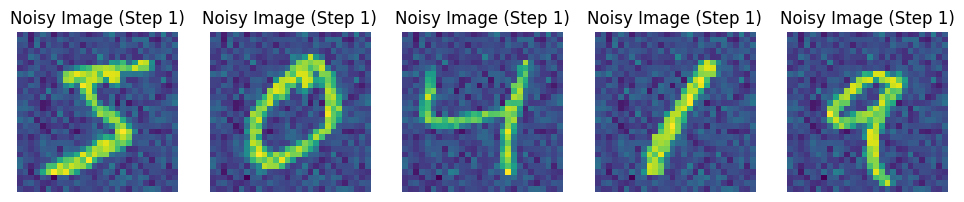

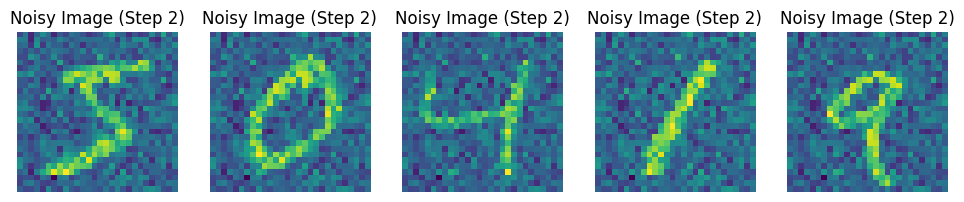

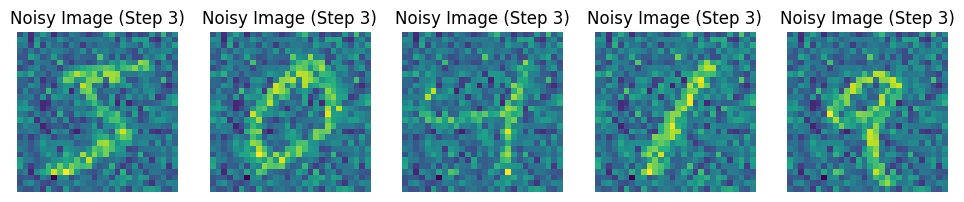

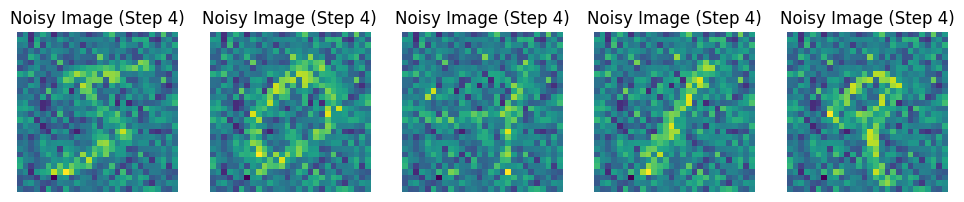

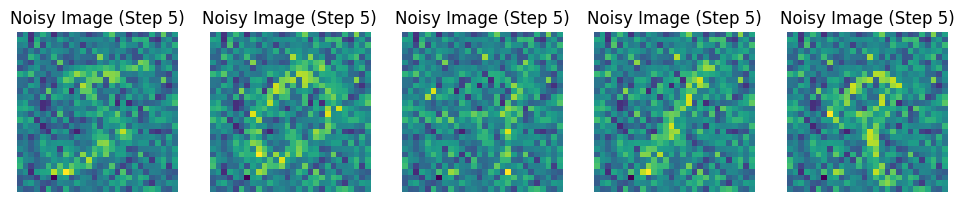

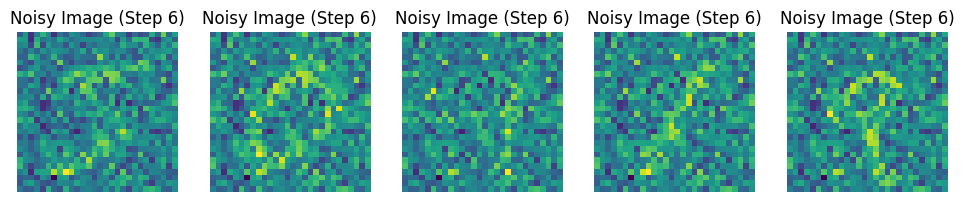

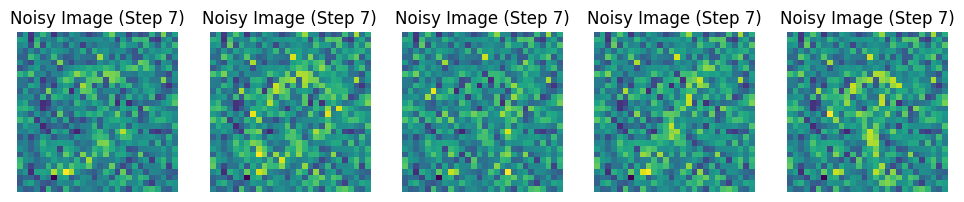

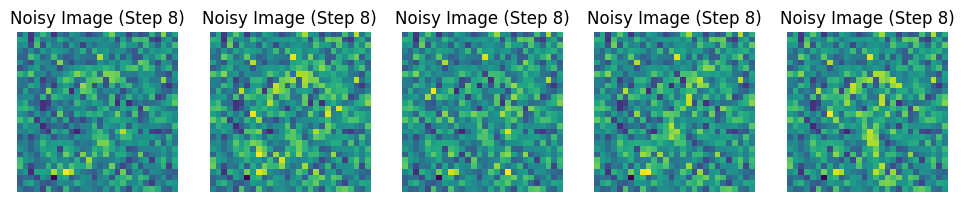

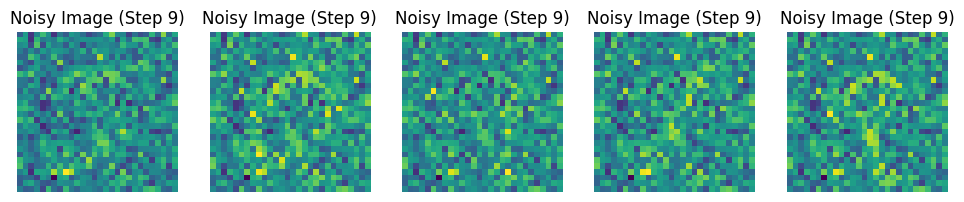

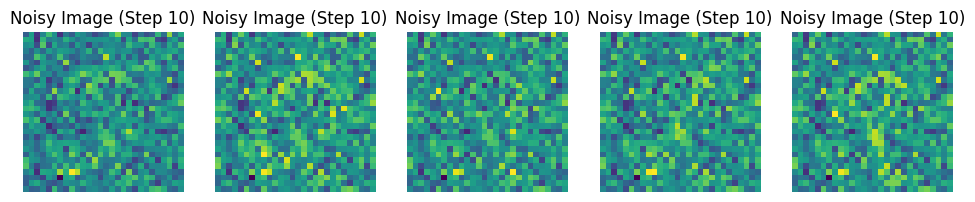

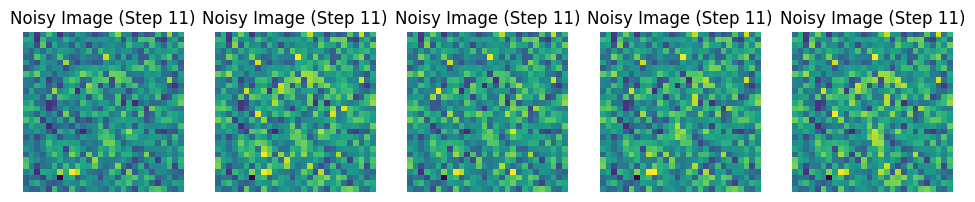

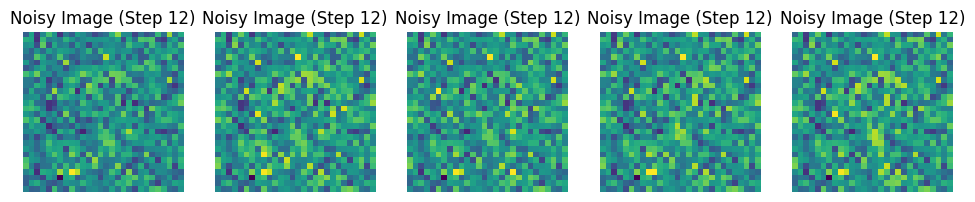

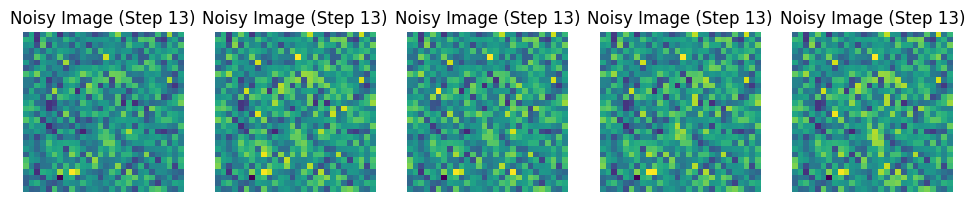

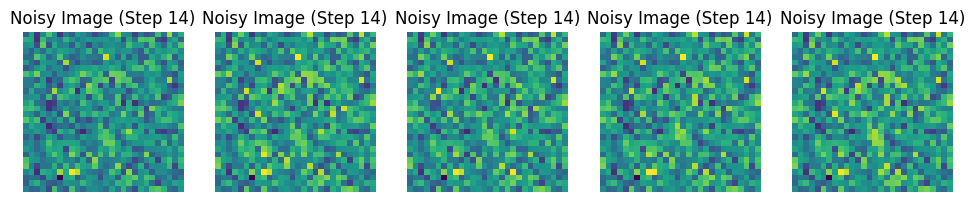

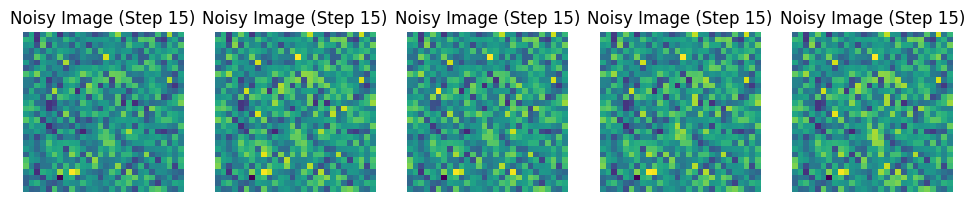

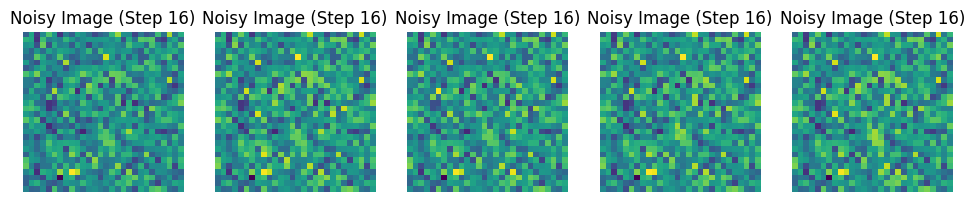

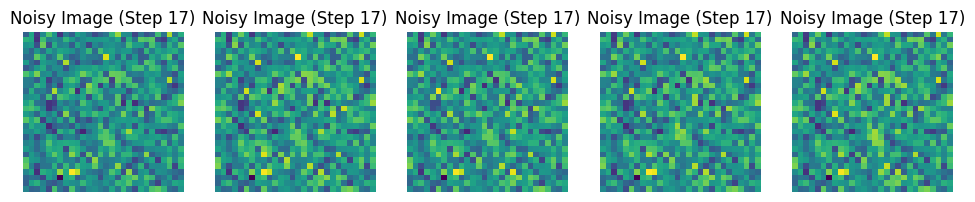

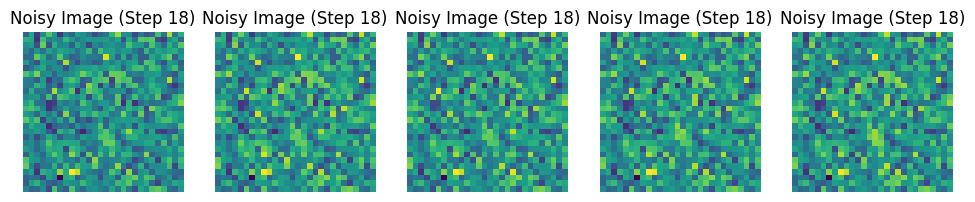

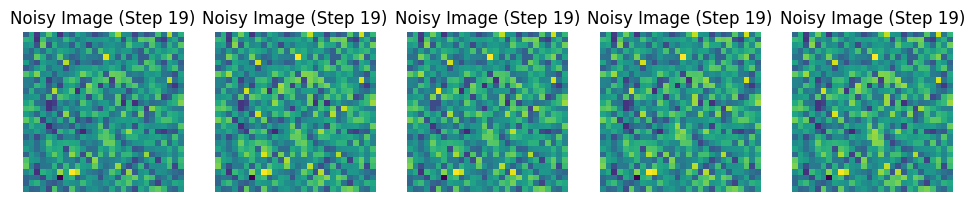

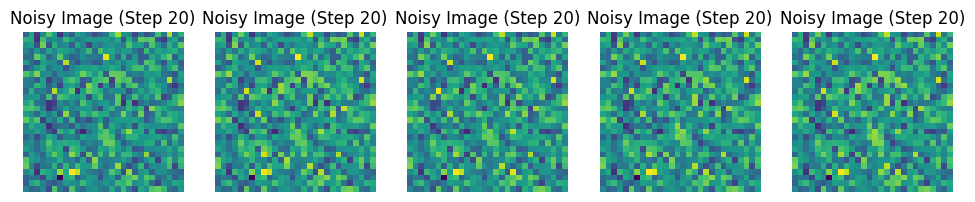

In [79]:



mean = 0
std_dev = 30
noise_distribution = np.random.normal(mean, std_dev, train_images[0].shape)

num_steps = 20  # Number of steps for the diffusive stochastic process
for step in range(num_steps):
    noisy_images = train_images + noise_distribution * (step + 1)
    
    # Display the noisy images
    fig, axes = plt.subplots(1, 5, figsize=(12, 3))
    for i in range(5):
        axes[i].imshow(noisy_images[i], cmap='viridis')
        axes[i].axis('off')
        axes[i].set_title(f'Noisy Image (Step {step+1})')
    plt.show()

In [115]:
w = np.random.rand((layers1))
layers1 = 2
n_qubits = 8
dev = qml.device('default.qubit', wires=n_qubits)

@qml.qnode(dev, interface='jax')
def quantum_nn(X, thetas):
    model = quantum_neural_network(n_wires=n_qubits)
    params_per_sublayer = 69
    for layer in range(layers1):
        model.QuantumMap(X)
        qml.Barrier()
        j = layer * params_per_sublayer
        model.QuantumRing_layer(thetas[j:j+(params_per_sublayer)],)
        j += (params_per_sublayer)*(layer)
        qml.Barrier(wires=range(n_qubits),only_visual=True)
    qml.Barrier(wires=range(n_qubits),only_visual=True)
    return qml.probs(wires=0)

In [ ]:
'''def binary_crossentropy(x, y, theta):
    labels = jnp.array(y)
    pred = jnp.array(qnn(x, theta))
    loss = 0
    for l, p in zip(labels, pred):
        loss += l * (jnp.log(p[l])) + (1 - l) * jnp.log(1 - p[1 - l])
    return -jnp.sum(loss)/len(labels)'''

In [129]:
@jax.jit
def loss(params, x, y):
    predictions = jnp.array(quantum_nn(x, params))
    epsilon = 1e-10 
    loss = 0
    for label, pred in zip(y, predictions):
        loss += label * jnp.log10(pred[label] + epsilon) + (1 - label)*jnp.log10(1 - pred[label] + epsilon)
    return -loss

In [146]:
qnn

<PjitFunction of <function quantum_nn at 0x39a046ef0>>

In [143]:
X_train[0].shape

(64,)

In [145]:
qnn_batched = jax.vmap(quantum_nn, (0, None,))
qnn = jax.jit(qnn_batched)

def cross_entropy_loss(logits, labels):
  labels_onehot = jax.nn.one_hot(labels, num_classes=2)
  return optax.softmax_cross_entropy(logits=logits, labels=labels_onehot).mean()

def compute_loss(params,images,labels):
    logits = qnn(images, params)
    print(logits)
    loss = cross_entropy_loss(logits=logits, labels=labels)
    return loss, logits


key = jax.random.PRNGKey(seed)
initial_params = jax.random.normal(key, shape=((param_per_gate * n_qubits + param_per_gate * entangling_gate +
                                                param_per_gate * n_qubits) * layers1,))

opt = optax.adam(learning_rate=0.3)
opt_state = opt.init(initial_params)

def update_step(opt, params, opt_state, x, y):
    loss_val, grads = jax.value_and_grad(compute_loss)(params, x, y)(params)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_val

loss_history = []

for i in range(100):
    params, opt_state, loss_val = update_step(opt, params, opt_state, X_train, y_train)


    print(f"Step: {i} Loss: {loss_val}")

    loss_history.append(loss_val)

IndexError: index is out of bounds for axis 0 with size 0

In [141]:
def update_step(opt, params, opt_state, x, y):
    loss_val, grads = jax.value_and_grad(compute_loss)(params, x, y)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_val

loss_history = []

for i in range(100):
    params, opt_state, loss_val = update_step(opt, params, opt_state, X_train, y_train)


    print(f"Step: {i} Loss: {loss_val}")

    loss_history.append(loss_val)

IndexError: index is out of bounds for axis 0 with size 0

In [ ]:
@jax.jit
def train_step(state, batch):
  """Train for a single step."""
  images, labels = batch
  (_, logits), grads = jax.value_and_grad(compute_loss, has_aux=True)(state.params,images,labels)
  state = state.apply_gradients(grads=grads)
  metrics = compute_metrics(logits=logits, labels=labels)
  return state, metrics